# Treebank NER with Bi-LSTM-CRF 

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="2";  

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

In [4]:
import pandas as pd
import numpy as np

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('paper')
sns.set_style('white')

In [6]:
from conlleval import evaluate

In [7]:
from ner_utils import *

Using TensorFlow backend.


## Get token data

In [8]:
#yap_dev = pd.read_csv('new_yap_outputs/yap_dev.csv.gz', compression='gzip')
#yap_test = pd.read_csv('new_yap_outputs/yap_test.csv.gz', compression='gzip')
yap_dev_tok = pd.read_csv('new_yap_outputs/yap_dev_tokens.csv.gz', compression='gzip').reset_index()
yap_test_tok = pd.read_csv('new_yap_outputs/yap_test_tokens.csv.gz', compression='gzip').reset_index()

In [9]:
yap_test_tok.head()

,index,sent,misc_token_id,misc_token_str,upostag,form,lemma,deprel,feats_gen,feats_num,feats_per,feats_tense,feats_suf_gen,feats_suf_num,feats_suf_per,sent_id
0,0,1,1,הכל,DEF^DTT,ה^כל,ה^כול,def^det,",",",",",",",",",",",",",",5439
1,1,1,2,נושאים,NN,נושאים,נושא,subj,M,P,NaN,NaN,NaN,NaN,NaN,5439
2,2,1,3,עמם,VB,עמם,עימם,conj,M,S,3,PAST,NaN,NaN,NaN,5439
3,3,1,4,את,AT,את,את,obj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5439
4,4,1,5,כישלונות,NNT,כישלונות,כישלון,hd,M,P,NaN,NaN,NaN,NaN,NaN,5439


In [10]:
tokens_ner_with_upos_feats = pd.read_csv('align/spmrl_tokens_df.csv.gz', compression='gzip').reset_index()

In [11]:
yap_dev_tok.head()

,index,sent,misc_token_id,misc_token_str,upostag,form,lemma,deprel,feats_gen,feats_num,feats_per,feats_tense,feats_suf_gen,feats_suf_num,feats_suf_per,sent_id
0,0,1,1,עשרות,CDT,עשרות,עשר,num,F,P,NaN,NaN,NaN,NaN,NaN,1
1,1,1,2,אנשים,NN,אנשים,איש,subj,M,P,NaN,NaN,NaN,NaN,NaN,1
2,2,1,3,מגיעים,BN,מגיעים,הגיע,conj,M,P,A,NaN,NaN,NaN,NaN,1
3,3,1,4,מתאילנד,PREPOSITION^NNP,מ^תאילנד,מ^תאילנד,comp^pobj,^F,^S,^,^,^,^,^,1
4,4,1,5,לישראל,NNP,לישראל,לישראל,nn,"F,M",S,NaN,NaN,NaN,NaN,NaN,1


In [12]:
yap_dev_tok_sents =  yap_dev_tok.groupby('sent_id')[['misc_token_str', 'upostag']].apply(lambda x: x.values.tolist())
yap_dev_tok_sents.head()

sent_id
1    [[עשרות, CDT], [אנשים, NN], [מגיעים, BN], [מתא...
2    [[תופעה, NN], [זו, PRP], [התבררה, VB], [אתמול,...
3    [[יו"ר, NNT], [הוועדה, DEF^NN], [,, yyCM], [ח"...
4    [[מצד, PREPOSITION^NN], [אחד, CD], [רוצה, BN],...
5    [[נמיר, NNP], [הודיעה, VB], [כי, CC], [תפנה, V...
dtype: object

In [13]:
yap_test_tok_sents =  yap_test_tok.groupby('sent_id')[['misc_token_str', 'upostag']].apply(lambda x: x.values.tolist())
yap_test_tok_sents.head()

sent_id
5439    [[הכל, DEF^DTT], [נושאים, NN], [עמם, VB], [את,...
5440    [[אומר, NNT], [מזכיר, NNT], [התק"ם, DEF^NNP], ...
5441    [[לא, RB], [ייתכן, MD], [שעולה, REL^NN], [יבוא...
5442    [[לא, RB], [ייתכן, MD], [שהוא, REL^PRP], [יירד...
5443    [[לכן, CC], [קבענו, VB], [עיקרון, NN], [שצריכה...
dtype: object

In [14]:
gold_dev  = tokens_ner_with_upos_feats[tokens_ner_with_upos_feats.set=='dev']
gold_train = tokens_ner_with_upos_feats[tokens_ner_with_upos_feats.set=='train']
gold_test = tokens_ner_with_upos_feats[tokens_ner_with_upos_feats.set=='test']

In [15]:
gold_dev_sents = gold_dev.groupby('sent_id')[['misc_token_str', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_train_sents = gold_train.groupby('sent_id')[['misc_token_str', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents = gold_test.groupby('sent_id')[['misc_token_str', 'upostag', 'biose']].apply(lambda x: x.values.tolist())
gold_test_sents.head()

sent_id
5439    [[הכל, NN, O], [נושאים, BN, O], [עמם, IN^S_PRN...
5440    [[אומר, BN, O], [מזכיר, NNT, O], [התק"ם, NNP, ...
5441    [[לא, RB, O], [ייתכן, MD, O], [שעולה, REL^NN, ...
5442    [[לא, RB, O], [ייתכן, MD, O], [שהוא, REL^PRP, ...
5443    [[לכן, CC, O], [קבענו, VB, O], [עיקרון, NN, O]...
dtype: object

In [16]:
gold_dev_sents.head()

sent_id
1    [[עשרות, CDT, O], [אנשים, NN, O], [מגיעים, BN,...
2    [[תופעה, NN, O], [זו, PRP, O], [התבררה, VB, O]...
3    [[יו"ר, NNT, O], [הוועדה, DEF^NN, O], [,, yyCM...
4    [[מצד, PREPOSITION^NN, O], [אחד, CD, O], [רוצה...
5    [[נמיר, NNP, S-PER], [הודיעה, VB, O], [כי, CC,...
dtype: object

In [17]:
words = list(set(tokens_ner_with_upos_feats.misc_token_str.values)|set(yap_dev_tok.misc_token_str.values)|set(yap_test_tok.misc_token_str.values))
n_words = len(words); n_words

28714

In [18]:
tags = list(set(tokens_ner_with_upos_feats.biose.values))
n_tags = len(tags); n_tags

36

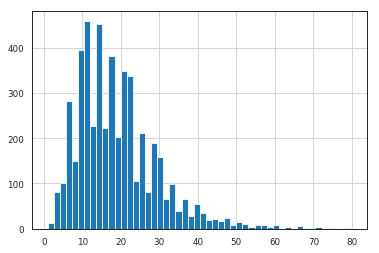

In [19]:
gold_train.groupby('sent_id').size().hist(bins=50)

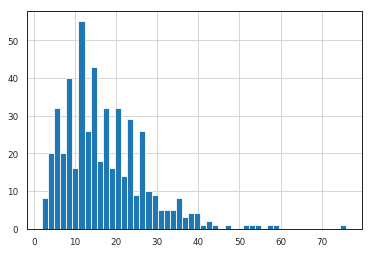

In [20]:
yap_dev_tok.groupby('sent_id').size().hist(bins=50)

In [21]:
max_len = 80
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["PAD"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

In [22]:
from keras.preprocessing.sequence import pad_sequences
X_gold_train = [[word2idx[w[0]] for w in s] for s in gold_train_sents]
X_gold_dev   = [[word2idx[w[0]] for w in s] for s in gold_dev_sents]
X_gold_test  = [[word2idx[w[0]] for w in s] for s in gold_test_sents]
X_yap_dev    = [[word2idx[w[0]] for w in s] for s in yap_dev_tok_sents]
X_yap_test   = [[word2idx[w[0]] for w in s] for s in yap_test_tok_sents]

In [23]:
X_gold_train = pad_sequences(maxlen=max_len, sequences=X_gold_train, value=word2idx["PAD"], padding='post', truncating='post')
X_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_gold_dev  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_test  = pad_sequences(maxlen=max_len, sequences=X_gold_test , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_yap_dev   , value=word2idx["PAD"], padding='post', truncating='post')
X_yap_test   = pad_sequences(maxlen=max_len, sequences=X_yap_test  , value=word2idx["PAD"], padding='post', truncating='post')
X_gold_train[0]

array([15394, 26686, 14306, 20846,  3015,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0],
      dtype=int32)

In [24]:
pos = list(set(tokens_ner_with_upos_feats.upostag.values)|set(yap_dev_tok.upostag.values)|set(yap_test_tok.upostag.values))
n_pos = len(pos); n_pos

352

In [25]:
pos2idx = {w: i+1 for i, w in enumerate(pos)}
pos2idx["PAD"] = 0

In [26]:
from keras.preprocessing.sequence import pad_sequences
X_pos_gold_train = [[pos2idx[w[1]] for w in s] for s in gold_train_sents]
X_pos_gold_dev   = [[pos2idx[w[1]] for w in s] for s in gold_dev_sents]
X_pos_gold_test  = [[pos2idx[w[1]] for w in s] for s in gold_test_sents]
X_pos_yap_dev    = [[pos2idx[w[1]] for w in s] for s in yap_dev_tok_sents]
X_pos_yap_test   = [[pos2idx[w[1]] for w in s] for s in yap_test_tok_sents]

In [27]:
X_pos_gold_train = pad_sequences(maxlen=max_len, sequences=X_pos_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_dev   = pad_sequences(maxlen=max_len, sequences=X_pos_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_test  = pad_sequences(maxlen=max_len, sequences=X_pos_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_dev    = pad_sequences(maxlen=max_len, sequences=X_pos_yap_dev   , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_yap_test   = pad_sequences(maxlen=max_len, sequences=X_pos_yap_test  , value=pos2idx["PAD"], padding='post', truncating='post')
X_pos_gold_train[0]

array([287, 188, 158,  20,  38,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0], dtype=int32)

In [28]:
from keras.preprocessing.sequence import pad_sequences
y_gold_train = [[tag2idx[w[2]] for w in s] for s in gold_train_sents]
y_gold_dev   = [[tag2idx[w[2]] for w in s] for s in gold_dev_sents]
y_gold_test  = [[tag2idx[w[2]] for w in s] for s in gold_test_sents]

In [29]:
y_numer_gold_train = pad_sequences(maxlen=max_len, sequences=y_gold_train, value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_dev   = pad_sequences(maxlen=max_len, sequences=y_gold_dev  , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_test  = pad_sequences(maxlen=max_len, sequences=y_gold_test , value=pos2idx["PAD"], padding='post', truncating='post')
y_numer_gold_train[0]

array([36, 36, 36, 36, 36,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=int32)

In [30]:
from keras.utils import to_categorical
y_gold_train = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_train]
y_gold_dev   = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_dev  ]
y_gold_test  = [to_categorical(i, num_classes=n_tags+1) for i in y_numer_gold_test ]

y_gold_train[0].shape

(80, 37)

In [31]:
validation_split = len(X_gold_dev) / (len(X_gold_train)+len(X_gold_dev))
validation_split

0.09196247930844216

In [32]:
splits = [[X_gold_train, X_gold_dev,
           y_gold_train, y_gold_dev,
           X_pos_gold_train, X_pos_gold_dev ]]

### Prep char input

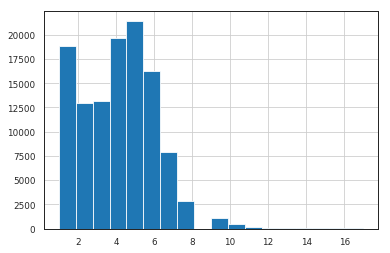

In [33]:
tokens_ner_with_upos_feats.misc_token_str.apply(len).hist(bins=18)

In [34]:
max_len_char = 12

In [35]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

50


In [36]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

In [37]:

def get_X_char(sents):
    X_char = []
    for sentence in sents:
        sent_seq = []
        for i in range(max_len):
            word_seq = []
            for j in range(max_len_char):
                try:
                    word_seq.append(char2idx.get(sentence[i][0][j]))
                except:
                    word_seq.append(char2idx.get("PAD"))
            sent_seq.append(word_seq)
        X_char.append(np.array(sent_seq))
    return X_char

In [38]:
X_char_gold_dev   = get_X_char(gold_dev_sents  )
X_char_gold_train = get_X_char(gold_train_sents)
X_char_gold_test  = get_X_char(gold_test_sents )
X_char_yap_dev    = get_X_char(yap_dev_tok_sents   )
X_char_yap_test   = get_X_char(yap_test_tok_sents  )



splits_char = [[X_char_gold_train, X_char_gold_dev,
                y_gold_train, y_gold_dev]]

## Embeddings

In [39]:
embedding_paths

{'yap_w2v_sg': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_skipgram.txt',
 'yap_w2v_cbow': '../wordembedding-hebrew/wikipedia.yap_form.word2vec_cbow.txt',
 'yap_glove': '../wordembedding-hebrew/glove/wikipedia.yap_form.glove.txt.txt',
 'yap_ft_sg': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_skipgram.model.vec',
 'yap_ft_cbow': '../wordembedding-hebrew/wikipedia.yap_form.fasttext_cbow.model.vec',
 'token_w2v_sg': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_skipgram.txt',
 'token_w2v_cbow': '../wordembedding-hebrew/wikipedia.tokenized.word2vec_cbow.txt',
 'token_glove': '../wordembedding-hebrew/glove/wikipedia.tokenized.glove.txt',
 'token_ft_sg': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_skipgram.model.vec',
 'token_ft_cbow': '../wordembedding-hebrew/wikipedia.tokenized.fasttext_cbow.model.vec',
 'pretrained_token_ft': '../fasttext/wiki.he.vec',
 'alt_tok_yap_w2v_sg': '../wordembedding-hebrew/wikipedia.alt_tok.yap_form.word2vec_skipgram.txt',
 'a

In [40]:
exclude = ['pretrained']
include = 'alt_tok'

In [41]:
embedding_mats = {}
for emb_name, emb_path in embedding_paths.items():
    skip=False
    if include not in emb_name:
        continue
        
    for exc in exclude:
        if exc in emb_path:
            skip=True
    if skip:
        continue
    embedding_mats[emb_name] = get_embedding_matrix(emb_path, word2idx)

loading word embeddings: ../wordembedding-hebrew/wikipedia.alt_tok.yap_form.word2vec_skipgram.txt
found 245642 word vectors
preparing embedding matrix...
number of null word embeddings: 12629
sample words not found:  ['בהדרכת' 'שעוד' 'שהופכת' 'הסרטות' 'ונשא' 'במאהל' 'העבירות' 'ונוסטלגי'
 'הססגוני' 'הברירה']
loading word embeddings: ../wordembedding-hebrew/wikipedia.alt_tok.yap_form.word2vec_cbow.txt
found 245642 word vectors
preparing embedding matrix...
number of null word embeddings: 12629
sample words not found:  ['גימראש' 'ולתיאטראות' 'מטאפיסית' 'מדבריה' 'כהניסטי' 'המכובדת' 'שנמסרה'
 'שהתועלת' 'ההספדים' 'הקרירה']
loading word embeddings: ../wordembedding-hebrew/glove/wikipedia.alt_tok.yap_form.glove.txt
found 245642 word vectors
preparing embedding matrix...
number of null word embeddings: 12629
sample words not found:  ['המולדת' 'ונקנס' 'שהשימוש' 'ושמאל' 'להומור' 'הלבנים' 'והישוותה' 'ל07'
 'כוננויות' 'הצמצום']
loading word embeddings: ../wordembedding-hebrew/wikipedia.alt_tok.yap_

## Model building

In [42]:
from ner_utils import *

In [43]:
configs = build_configs(base_configs_stack_freeze, embedding_mats)
configs     

[{'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'alt_tok_yap_w2v_sg',
  'trainable': False,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'alt_tok_yap_w2v_cbow',
  'trainable': False,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'alt_tok_yap_glove',
  'trainable': False,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf': True,
  'use_pos': False,
  'embedding_matrix': 'alt_tok_yap_ft_sg',
  'trainable': False,
  'stack_lstm': 2},
 {'optimizer': 'adam',
  'output_dropout': True,
  'add_random_embedding': False,
  'use_char': True,
  'crf

In [44]:
for conf in configs:
    conf['patience'] = 10

In [45]:
out_folder = 'results/new_outputs_alt_tok'
if not os.path.exists(out_folder):
    os.mkdir(out_folder)

In [46]:
extra_preds = [(X_gold_test, X_pos_gold_test, X_char_gold_test), 
               (X_yap_dev, X_pos_yap_dev, X_char_yap_dev),
               (X_yap_test, X_pos_yap_test, X_char_yap_test)]

In [47]:
from ner_utils import *

Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 97s - loss: 0.4325 - crf_accuracy: 0.9116 - val_loss: 0.1882 - val_crf_accuracy: 0.9680
Epoch 2/100
 - 88s - loss: 0.1392 - crf_accuracy: 0.9751 - val_loss: 0.1553 - val_crf_accuracy: 0.9682
Epoch 3/100
 - 89s - loss: 0.1140 - crf_accuracy: 0.9756 - val_loss: 0.1350 - val_crf_accuracy: 0.9692
Epoch 4/100
 - 87s - loss: 0.0999 - crf_accuracy: 0.9767 - val_loss: 0.1235 - val_crf_accuracy: 0.9715
Epoch 5/100
 - 87s - loss: 0.0914 - crf_accuracy: 0.9780 - val_loss: 0.1103 - val_crf_accuracy: 0.9724
Epoch 6/100
 - 97s - loss: 0.0834 - crf_accuracy: 0.9789 - val_loss: 0.0997 - val_crf_accuracy: 0.9744
Epoch 7/100
 - 95s - loss: 0.0753 - crf_accuracy: 0.9802 - val_loss: 0.0901 - val_crf_accuracy: 0.9750
Epoch 8/100
 - 98s - loss: 0.0676 - crf_accuracy: 0.9816 - val_loss: 0.0851 - val_crf_accuracy: 0.9762
Epoch 9/100
 - 98s - loss: 0.0629 - crf_accuracy: 0.9820 - val_loss: 0.0786 - val_crf_accuracy: 0.9761
Epoch 10/100
 - 94s - loss

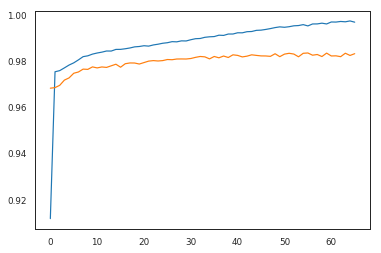

processed 8531 tokens with 499 phrases; found: 422 phrases; correct: 294.
accuracy:  55.66%; (non-O)
accuracy:  94.75%; precision:  69.67%; recall:  58.92%; FB1:  63.84
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  75.00%; recall:  69.42%; FB1:  72.10  112
              LOC: precision:  38.46%; recall:  17.86%; FB1:  24.39  13
              ORG: precision:  58.89%; recall:  44.54%; FB1:  50.72  90
              PER: precision:  74.26%; recall:  77.72%; FB1:  75.95  202
              WOA: precision:  50.00%; recall:  22.22%; FB1:  30.77  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 103s - loss: 0.4721 - crf_accuracy: 0.8995 - val_loss: 0.1778 - val_crf_accuracy: 0.9679
Epoch 2/100
 - 91s - loss: 0.1297 -

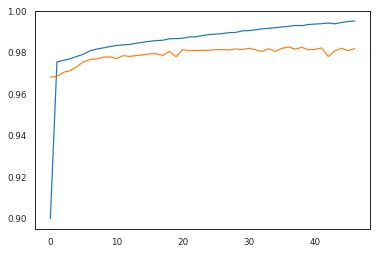

processed 8531 tokens with 499 phrases; found: 401 phrases; correct: 294.
accuracy:  56.27%; (non-O)
accuracy:  94.95%; precision:  73.32%; recall:  58.92%; FB1:  65.33
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              FAC: precision:  50.00%; recall:   8.33%; FB1:  14.29  2
              GPE: precision:  82.65%; recall:  66.94%; FB1:  73.97  98
              LOC: precision:  45.45%; recall:  17.86%; FB1:  25.64  11
              ORG: precision:  64.77%; recall:  47.90%; FB1:  55.07  88
              PER: precision:  76.44%; recall:  75.65%; FB1:  76.04  191
              WOA: precision:  40.00%; recall:  44.44%; FB1:  42.11  10
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 100s - loss: 0.4026 - crf_accuracy: 0.9237 - val_loss: 0.1539 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 95s - loss: 0.1110 -

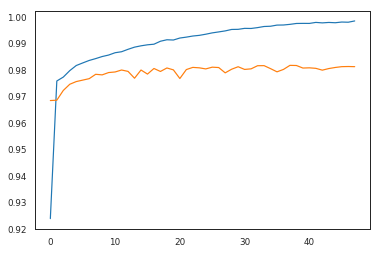

processed 8531 tokens with 499 phrases; found: 414 phrases; correct: 277.
accuracy:  51.81%; (non-O)
accuracy:  94.53%; precision:  66.91%; recall:  55.51%; FB1:  60.68
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  6
              GPE: precision:  77.88%; recall:  66.94%; FB1:  72.00  104
              LOC: precision:  40.00%; recall:  21.43%; FB1:  27.91  15
              ORG: precision:  51.72%; recall:  37.82%; FB1:  43.69  87
              PER: precision:  73.33%; recall:  74.09%; FB1:  73.71  195
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  5
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 109s - loss: 0.3725 - crf_accuracy: 0.9317 - val_loss: 0.1648 - val_crf_accuracy: 0.9682
Epoch 2/100
 - 95s - loss: 0.1144 -

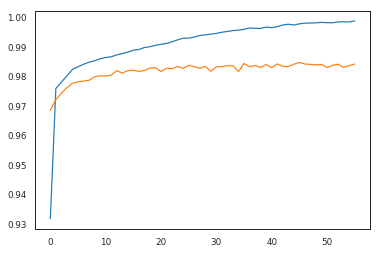

processed 8531 tokens with 499 phrases; found: 410 phrases; correct: 301.
accuracy:  56.75%; (non-O)
accuracy:  95.17%; precision:  73.41%; recall:  60.32%; FB1:  66.23
              ANG: precision:  66.67%; recall:  66.67%; FB1:  66.67  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  82.41%; recall:  73.55%; FB1:  77.73  108
              LOC: precision:  61.54%; recall:  28.57%; FB1:  39.02  13
              ORG: precision:  63.64%; recall:  41.18%; FB1:  50.00  77
              PER: precision:  73.89%; recall:  77.72%; FB1:  75.76  203
              WOA: precision:  50.00%; recall:  33.33%; FB1:  40.00  6
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 99s - loss: 0.3732 - crf_accuracy: 0.9388 - val_loss: 0.1350 - val_crf_accuracy: 0.9684
Epoch 2/100
 - 86s - loss: 0.0974 - 

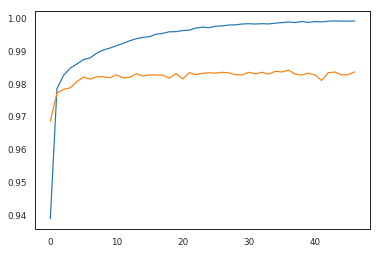

processed 8531 tokens with 499 phrases; found: 411 phrases; correct: 285.
accuracy:  55.30%; (non-O)
accuracy:  94.88%; precision:  69.34%; recall:  57.11%; FB1:  62.64
              ANG: precision:  66.67%; recall:  66.67%; FB1:  66.67  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:  10.00%; recall:   8.33%; FB1:   9.09  10
              GPE: precision:  77.57%; recall:  68.60%; FB1:  72.81  107
              LOC: precision:  37.50%; recall:  21.43%; FB1:  27.27  16
              ORG: precision:  58.14%; recall:  42.02%; FB1:  48.78  86
              PER: precision:  78.65%; recall:  72.54%; FB1:  75.47  178
              WOA: precision:  22.22%; recall:  22.22%; FB1:  22.22  9
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 104s - loss: 0.4211 - crf_accuracy: 0.9241 - val_loss: 0.1805 - val_crf_accuracy: 0.9682
Epoch 2/100
 - 93s - loss: 0.1359 

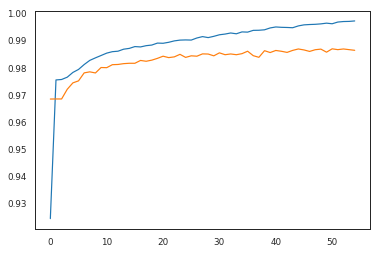

processed 8531 tokens with 499 phrases; found: 437 phrases; correct: 333.
accuracy:  64.94%; (non-O)
accuracy:  96.03%; precision:  76.20%; recall:  66.73%; FB1:  71.15
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  78.07%; recall:  73.55%; FB1:  75.74  114
              LOC: precision:  83.33%; recall:  53.57%; FB1:  65.22  18
              ORG: precision:  69.89%; recall:  54.62%; FB1:  61.32  93
              PER: precision:  79.90%; recall:  84.46%; FB1:  82.12  204
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 106s - loss: 0.4753 - crf_accuracy: 0.8993 - val_loss: 0.1788 - val_crf_accuracy: 0.9682
Epoch 2/100
 - 86s - loss: 0.1270 -

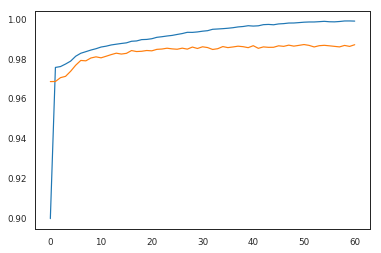

processed 8531 tokens with 499 phrases; found: 433 phrases; correct: 331.
accuracy:  64.34%; (non-O)
accuracy:  95.91%; precision:  76.44%; recall:  66.33%; FB1:  71.03
              ANG: precision: 100.00%; recall:  33.33%; FB1:  50.00  1
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              GPE: precision:  79.49%; recall:  76.86%; FB1:  78.15  117
              LOC: precision:  65.22%; recall:  53.57%; FB1:  58.82  23
              ORG: precision:  78.05%; recall:  53.78%; FB1:  63.68  82
              PER: precision:  77.61%; recall:  80.83%; FB1:  79.19  201
              WOA: precision:  25.00%; recall:  22.22%; FB1:  23.53  8
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 108s - loss: 0.4156 - crf_accuracy: 0.9224 - val_loss: 0.1369 - val_crf_accuracy: 0.9682
Epoch 2/100
 - 93s - loss: 0.1022 -

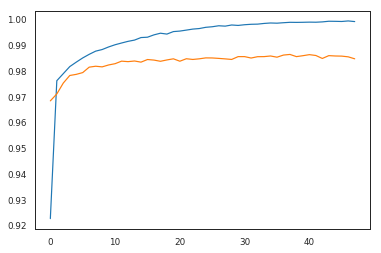

processed 8531 tokens with 499 phrases; found: 450 phrases; correct: 322.
accuracy:  61.33%; (non-O)
accuracy:  95.53%; precision:  71.56%; recall:  64.53%; FB1:  67.86
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              FAC: precision:  20.00%; recall:   8.33%; FB1:  11.76  5
              GPE: precision:  77.12%; recall:  75.21%; FB1:  76.15  118
              LOC: precision:  59.26%; recall:  57.14%; FB1:  58.18  27
              ORG: precision:  58.70%; recall:  45.38%; FB1:  51.18  92
              PER: precision:  78.00%; recall:  80.83%; FB1:  79.39  200
              WOA: precision:  40.00%; recall:  22.22%; FB1:  28.57  5
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 115s - loss: 0.4089 - crf_accuracy: 0.9225 - val_loss: 0.1707 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 98s - loss: 0.1136 -

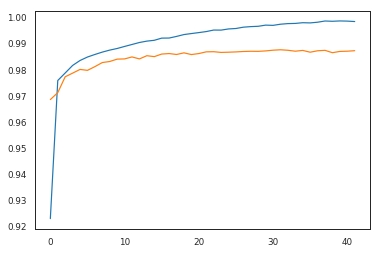

processed 8531 tokens with 499 phrases; found: 454 phrases; correct: 354.
accuracy:  67.35%; (non-O)
accuracy:  96.32%; precision:  77.97%; recall:  70.94%; FB1:  74.29
              ANG: precision: 100.00%; recall:  66.67%; FB1:  80.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  85.71%; recall:  79.34%; FB1:  82.40  112
              LOC: precision:  65.52%; recall:  67.86%; FB1:  66.67  29
              ORG: precision:  70.71%; recall:  58.82%; FB1:  64.22  99
              PER: precision:  80.98%; recall:  86.01%; FB1:  83.42  205
              WOA: precision:  25.00%; recall:  11.11%; FB1:  15.38  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 117s - loss: 0.3830 - crf_accuracy: 0.9247 - val_loss: 0.1283 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 96s - loss: 0.0925 -

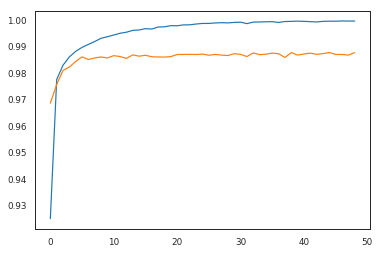

processed 8531 tokens with 499 phrases; found: 434 phrases; correct: 334.
accuracy:  65.66%; (non-O)
accuracy:  96.16%; precision:  76.96%; recall:  66.93%; FB1:  71.60
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:  50.00%; recall:   8.33%; FB1:  14.29  2
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
              GPE: precision:  86.54%; recall:  74.38%; FB1:  80.00  104
              LOC: precision:  79.17%; recall:  67.86%; FB1:  73.08  24
              ORG: precision:  61.17%; recall:  52.94%; FB1:  56.76  103
              PER: precision:  82.01%; recall:  80.31%; FB1:  81.15  189
              WOA: precision:  60.00%; recall:  33.33%; FB1:  42.86  5
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 121s - loss: 0.4993 - crf_accuracy: 0.8953 - val_loss: 0.1827 - val_crf_accuracy: 0.9680
Epoch 2/100
 - 87s - loss: 0.1382 

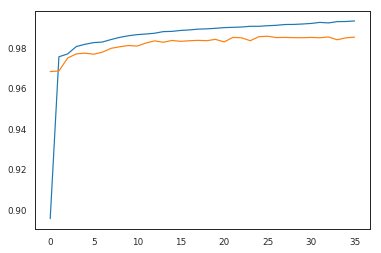

processed 8531 tokens with 499 phrases; found: 431 phrases; correct: 326.
accuracy:  59.28%; (non-O)
accuracy:  95.71%; precision:  75.64%; recall:  65.33%; FB1:  70.11
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              GPE: precision:  81.51%; recall:  80.17%; FB1:  80.83  119
              LOC: precision:  50.00%; recall:   7.14%; FB1:  12.50  4
              ORG: precision:  57.30%; recall:  42.86%; FB1:  49.04  89
              PER: precision:  80.73%; recall:  91.19%; FB1:  85.64  218
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 114s - loss: 0.4548 - crf_accuracy: 0.8976 - val_loss: 0.1791 - val_crf_accuracy: 0.9674
Epoch 2/100
 - 101s - loss: 0.1319 -

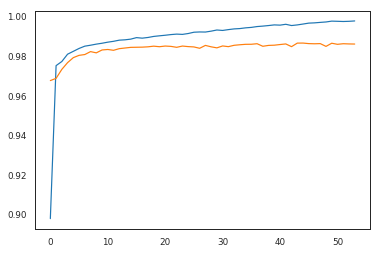

processed 8531 tokens with 499 phrases; found: 437 phrases; correct: 336.
accuracy:  62.65%; (non-O)
accuracy:  96.01%; precision:  76.89%; recall:  67.33%; FB1:  71.79
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              FAC: precision:  14.29%; recall:   8.33%; FB1:  10.53  7
              GPE: precision:  83.19%; recall:  77.69%; FB1:  80.34  113
              LOC: precision:  50.00%; recall:  25.00%; FB1:  33.33  14
              ORG: precision:  62.11%; recall:  49.58%; FB1:  55.14  95
              PER: precision:  86.63%; recall:  90.67%; FB1:  88.61  202
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 118s - loss: 0.3906 - crf_accuracy: 0.9266 - val_loss: 0.1557 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 88s - loss: 0.1086 -

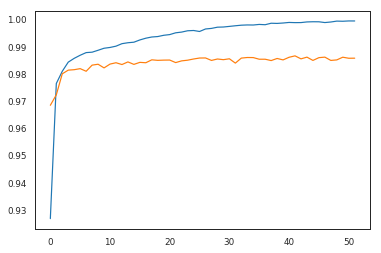

processed 8531 tokens with 499 phrases; found: 453 phrases; correct: 334.
accuracy:  62.17%; (non-O)
accuracy:  95.70%; precision:  73.73%; recall:  66.93%; FB1:  70.17
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              FAC: precision:  25.00%; recall:   8.33%; FB1:  12.50  4
              GPE: precision:  78.07%; recall:  73.55%; FB1:  75.74  114
              LOC: precision:  50.00%; recall:  21.43%; FB1:  30.00  12
              ORG: precision:  54.17%; recall:  43.70%; FB1:  48.37  96
              PER: precision:  84.11%; recall:  93.26%; FB1:  88.45  214
              WOA: precision:  37.50%; recall:  33.33%; FB1:  35.29  8
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 119s - loss: 0.3765 - crf_accuracy: 0.9357 - val_loss: 0.1668 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 91s - loss: 0.1140 -

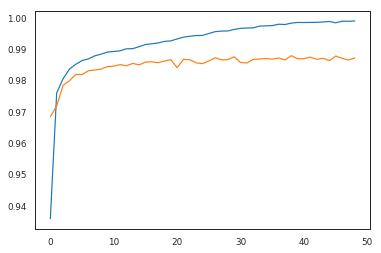

processed 8531 tokens with 499 phrases; found: 459 phrases; correct: 345.
accuracy:  64.58%; (non-O)
accuracy:  95.93%; precision:  75.16%; recall:  69.14%; FB1:  72.03
              ANG: precision:  75.00%; recall: 100.00%; FB1:  85.71  4
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
              GPE: precision:  87.16%; recall:  78.51%; FB1:  82.61  109
              LOC: precision:  45.00%; recall:  32.14%; FB1:  37.50  20
              ORG: precision:  63.10%; recall:  44.54%; FB1:  52.22  84
              PER: precision:  79.39%; recall:  93.78%; FB1:  85.99  228
              WOA: precision:  33.33%; recall:  33.33%; FB1:  33.33  9
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 120s - loss: 0.3702 - crf_accuracy: 0.9315 - val_loss: 0.1373 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 98s - loss: 0.0980 -

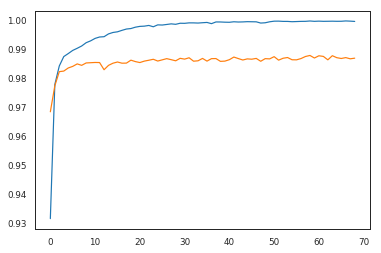

processed 8531 tokens with 499 phrases; found: 449 phrases; correct: 342.
accuracy:  65.66%; (non-O)
accuracy:  96.17%; precision:  76.17%; recall:  68.54%; FB1:  72.15
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              EVE: precision:  66.67%; recall:  16.67%; FB1:  26.67  3
              FAC: precision:  14.29%; recall:   8.33%; FB1:  10.53  7
              GPE: precision:  87.38%; recall:  74.38%; FB1:  80.36  103
              LOC: precision:  38.10%; recall:  28.57%; FB1:  32.65  21
              ORG: precision:  62.64%; recall:  47.90%; FB1:  54.29  91
              PER: precision:  83.57%; recall:  92.23%; FB1:  87.68  213
              WOA: precision:  42.86%; recall:  33.33%; FB1:  37.50  7
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 126s - loss: 0.4176 - crf_accuracy: 0.9176 - val_loss: 0.1781 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 86s - loss: 0.1315 -

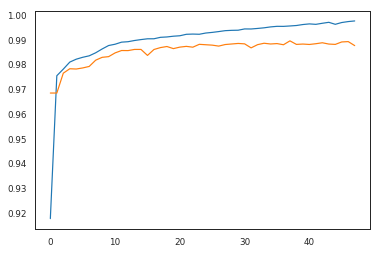

processed 8531 tokens with 499 phrases; found: 447 phrases; correct: 359.
accuracy:  66.87%; (non-O)
accuracy:  96.57%; precision:  80.31%; recall:  71.94%; FB1:  75.90
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  83.48%; recall:  79.34%; FB1:  81.36  115
              LOC: precision:  75.00%; recall:  64.29%; FB1:  69.23  24
              ORG: precision:  75.00%; recall:  52.94%; FB1:  62.07  84
              PER: precision:  83.80%; recall:  93.78%; FB1:  88.51  216
              WOA: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 133s - loss: 0.4714 - crf_accuracy: 0.9033 - val_loss: 0.1729 - val_crf_accuracy: 0.9682
Epoch 2/100
 - 93s - loss: 0.1250 -

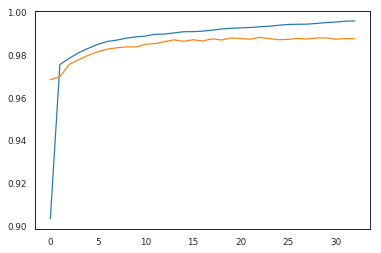

processed 8531 tokens with 499 phrases; found: 456 phrases; correct: 360.
accuracy:  66.99%; (non-O)
accuracy:  96.38%; precision:  78.95%; recall:  72.14%; FB1:  75.39
              ANG: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  82.79%; recall:  83.47%; FB1:  83.13  122
              LOC: precision:  68.75%; recall:  39.29%; FB1:  50.00  16
              ORG: precision:  71.43%; recall:  54.62%; FB1:  61.90  91
              PER: precision:  82.73%; recall:  94.30%; FB1:  88.14  220
              WOA: precision:  25.00%; recall:  11.11%; FB1:  15.38  4
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 122s - loss: 0.3356 - crf_accuracy: 0.9439 - val_loss: 0.1406 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 85s - loss: 0.0959 -

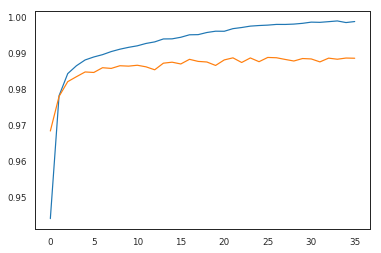

processed 8531 tokens with 499 phrases; found: 472 phrases; correct: 361.
accuracy:  66.99%; (non-O)
accuracy:  96.40%; precision:  76.48%; recall:  72.34%; FB1:  74.36
              ANG: precision:  50.00%; recall:  33.33%; FB1:  40.00  2
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  3
              GPE: precision:  81.40%; recall:  86.78%; FB1:  84.00  129
              LOC: precision:  51.61%; recall:  57.14%; FB1:  54.24  31
              ORG: precision:  69.05%; recall:  48.74%; FB1:  57.14  84
              PER: precision:  82.11%; recall:  92.75%; FB1:  87.10  218
              WOA: precision:  40.00%; recall:  22.22%; FB1:  28.57  5
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 124s - loss: 0.3603 - crf_accuracy: 0.9390 - val_loss: 0.1618 - val_crf_accuracy: 0.9683
Epoch 2/100
 - 92s - loss: 0.1057 -

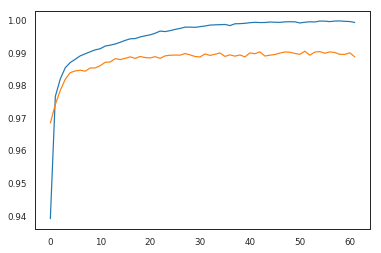

processed 8531 tokens with 499 phrases; found: 467 phrases; correct: 385.
accuracy:  72.17%; (non-O)
accuracy:  97.01%; precision:  82.44%; recall:  77.15%; FB1:  79.71
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              EVE: precision: 100.00%; recall:   8.33%; FB1:  15.38  1
              FAC: precision:   0.00%; recall:   0.00%; FB1:   0.00  2
              GPE: precision:  83.87%; recall:  85.95%; FB1:  84.90  124
              LOC: precision:  76.19%; recall:  57.14%; FB1:  65.31  21
              ORG: precision:  79.38%; recall:  64.71%; FB1:  71.30  97
              PER: precision:  85.78%; recall:  93.78%; FB1:  89.60  211
              WOA: precision:  37.50%; recall:  33.33%; FB1:  35.29  8
Train on 4482 samples, validate on 455 samples
Epoch 1/100
 - 127s - loss: 0.3884 - crf_accuracy: 0.9280 - val_loss: 0.1344 - val_crf_accuracy: 0.9687
Epoch 2/100
 - 83s - loss: 0.0902 -

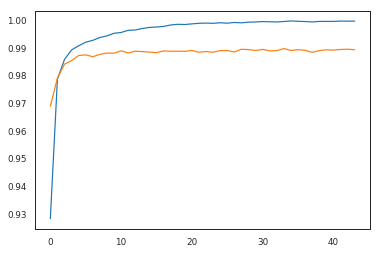

processed 8531 tokens with 499 phrases; found: 481 phrases; correct: 377.
accuracy:  72.53%; (non-O)
accuracy:  96.84%; precision:  78.38%; recall:  75.55%; FB1:  76.94
              ANG: precision: 100.00%; recall: 100.00%; FB1: 100.00  3
              DUC: precision:   0.00%; recall:   0.00%; FB1:   0.00  1
              EVE: precision:  50.00%; recall:   8.33%; FB1:  14.29  2
              FAC: precision:   8.33%; recall:   8.33%; FB1:   8.33  12
              GPE: precision:  89.29%; recall:  82.64%; FB1:  85.84  112
              LOC: precision:  61.54%; recall:  57.14%; FB1:  59.26  26
              ORG: precision:  69.00%; recall:  57.98%; FB1:  63.01  100
              PER: precision:  84.26%; recall:  94.30%; FB1:  89.00  216
              WOA: precision:  55.56%; recall:  55.56%; FB1:  55.56  9


In [48]:
configs, results, preds, histories = run_models(configs, splits, splits_char, embedding_mats, 
                                                words, max_len, n_words, idx2word, idx2tag,
                                                n_tags, max_len_char, n_pos, n_chars,
                                                run_name='treebank_tokens_alt_tok2', out_folder=out_folder,
                                                skip_if_model_exists=True,
                                                validation_split=validation_split,
                                                extra_predictions=extra_preds,
                                                )

In [70]:
from keras import backend as K
K.clear_session()